In [2]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

import folium
import uuid

In [3]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels
roads = db.roads

In [4]:
# Load the expanded names of keys and human-readable codes into memory
expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

In [5]:
def results_to_table(results, index_name, column_name, results_name, 
                     fillna=None,
                     relabel_index=False, relabel_columns=False,
                     index_label=None, column_label=None):
    
    # Move items in dicts-of-dicts to the top level.
    def flatten(d):
        new_d = {}
        for k in d:
            if isinstance(d[k], dict):
                new_d.update(flatten(d[k]))
            else:
                new_d[k] = d[k]
        return new_d

    df = pd.DataFrame([flatten(r) for r in results])
    df = df.pivot(index=index_name, columns=column_name, values=results_name)
    
    # Optionally, fiddle with names and labels to make the DataFrame pretty.
    if not fillna is None:
        df.fillna(fillna, inplace=True)
    if relabel_columns:
        df.columns = [label_of[column_name, c] for c in df.columns]
    if relabel_index:
        df.index = [label_of[index_name, r] for r in df.index]
    if column_label:
        df.columns.name = column_label
    else:
        df.columns.name = column_name
    if index_label:
        df.index.name = index_label
    else:
        df.index.name = index_name
    return df

# Activity 1

In [6]:
pipeline = [
    {'$project': {'ONS LA Name': '$ONS LA Name',
                  'class': {'$substr': ['$RCat', 1, 1]},
                  'LenNet': '$LenNet'}},
    {'$match': {'class': {'$in': ['R', 'U']}}},
    {'$group': {'_id': {'ONS_LA_Name': '$ONS LA Name', 
                        'class': '$class'},
                    'length': {'$sum': '$LenNet'},
                    'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': {'ONS_LA_Name': 'Croydon', 'class': 'R'}, 'count': 1, 'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Barking and Dagenham', 'class': 'R'},
  'count': 1,
  'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Harrow', 'class': 'R'}, 'count': 1, 'length': 0.6},
 {'_id': {'ONS_LA_Name': 'Dundee City', 'class': 'R'},
  'count': 3,
  'length': 2.7},
 {'_id': {'ONS_LA_Name': 'Reading', 'class': 'R'}, 'count': 1, 'length': 0.3},
 {'_id': {'ONS_LA_Name': 'Plymouth', 'class': 'R'}, 'count': 2, 'length': 4.2},
 {'_id': {'ONS_LA_Name': 'Manchester', 'class': 'R'},
  'count': 1,
  'length': 2.0},
 {'_id': {'ONS_LA_Name': 'Poole', 'class': 'R'}, 'count': 5, 'length': 7.0},
 {'_id': {'ONS_LA_Name': 'Moray', 'class': 'U'}, 'count': 6, 'length': 7.5},
 {'_id': {'ONS_LA_Name': 'Birmingham', 'class': 'R'},
  'count': 4,
  'length': 6.1},
 {'_id': {'ONS_LA_Name': 'Havering', 'class': 'R'}, 'count': 4, 'length': 8.5},
 {'_id': {'ONS_LA_Name': 'Aberdeenshire', 'class': 'U'},
  'count': 8,
  'length': 12.0},
 {'_i

In [6]:
ons_class_df = results_to_table(results, 'ONS_LA_Name', 'class', 'count', fillna=0)
ons_class_df

class,R,U
ONS_LA_Name,,
Aberdeen City,14.0,44.0
Aberdeenshire,119.0,8.0
Angus,40.0,19.0
Argyll & Bute,73.0,3.0
Barking and Dagenham,1.0,26.0
Barnet,10.0,84.0
Barnsley,36.0,34.0
Bath and North East Somerset,33.0,45.0
Bedford,31.0,35.0


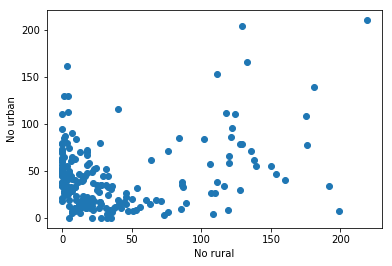

In [7]:
plt.scatter(ons_class_df['R'], 
            ons_class_df['U']
            )
plt.xlabel('No rural')
plt.ylabel('No urban')
plt.show()

In [8]:
# Which is that district in the top-right corner?
ons_class_df.loc[ons_class_df['R'].idxmax()]

class
R    219.0
U    210.0
Name: Kent, dtype: float64

Find the most rural and urban districts.

In [9]:
ons_class_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Surrey,129.0,204.0
Lancashire,133.0,166.0
Liverpool,3.0,161.0
Hertfordshire,111.0,153.0


In [10]:
ons_class_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Highland,199.0,7.0
Devon,192.0,34.0
Staffordshire,181.0,139.0
Derbyshire,176.0,77.0


In [11]:
ons_class_df[(ons_class_df['R'] > 150) | (ons_class_df['U'] > 150)]

class,R,U
ONS_LA_Name,,
Derbyshire,176.0,77.0
Devon,192.0,34.0
Hampshire,175.0,108.0
Hertfordshire,111.0,153.0
Highland,199.0,7.0
Kent,219.0,210.0
Lancashire,133.0,166.0
Lincolnshire,154.0,47.0
Liverpool,3.0,161.0


In [12]:
ons_class_df[(ons_class_df['R'] < 2) | (ons_class_df['U'] < 2)]

class,R,U
ONS_LA_Name,,
Barking and Dagenham,1.0,26.0
Brent,0.0,50.0
Camden,0.0,78.0
City of London,0.0,38.0
Comhairle nan Eilean Siar,28.0,0.0
Croydon,1.0,65.0
Ealing,0.0,48.0
Greenwich,0.0,61.0
Hackney,0.0,56.0


Now to look at the road lengths.

In [13]:
ons_class_len_df = results_to_table(results, 'ONS_LA_Name', 'class', 'length', fillna=0)
ons_class_len_df

class,R,U
ONS_LA_Name,,
Aberdeen City,28.20,59.60
Aberdeenshire,872.30,12.00
Angus,216.00,26.00
Argyll & Bute,788.90,8.00
Barking and Dagenham,0.40,36.70
Barnet,12.00,84.40
Barnsley,100.60,50.00
Bath and North East Somerset,96.60,36.80
Bedford,85.67,23.60


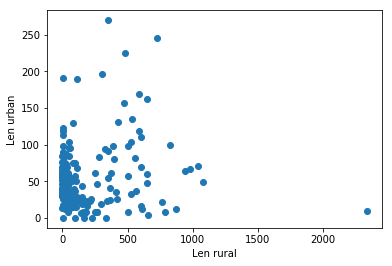

In [14]:
plt.scatter(ons_class_len_df['R'], 
            ons_class_len_df['U']
            )
plt.xlabel('Len rural')
plt.ylabel('Len urban')
plt.show()

Again, look at the most urban and most rural.

In [15]:
ons_class_len_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Surrey,349.72,269.57
Kent,727.64,245.60
Lancashire,476.50,224.30
Hertfordshire,300.40,195.90
Birmingham,6.10,191.10


In [16]:
ons_class_len_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Highland,2335.20,9.6
Devon,1082.37,49.4
Lincolnshire,1037.41,70.7
North Yorkshire,982.50,66.2
Cumbria,942.90,64.4


There are a lot of districts on that left hand edge of the scatter plot. Can we pick them out? How about by finding the ratio of urban:rural lengths, and finding the outliers.

In [17]:
ons_class_len_df['UvR'] = ons_class_len_df['U'] / ons_class_len_df['R']
ons_class_len_df.sort_values('UvR').head(10)

class,R,U,UvR
ONS_LA_Name,,,
Shetland Islands,225.0,0.00,0.000000
Rutland,95.5,0.00,0.000000
Orkney Islands,163.8,0.00,0.000000
Isles of Scilly,7.7,0.00,0.000000
Comhairle nan Eilean Siar,333.3,0.00,0.000000
Highland,2335.2,9.60,0.004111
Powys,657.2,3.30,0.005021
Argyll & Bute,788.9,8.00,0.010141
Aberdeenshire,872.3,12.00,0.013757


In [18]:
ons_class_len_df.sort_values('UvR', ascending=False).head(10)

class,R,U,UvR
ONS_LA_Name,,,
Brent,0.0,52.80,inf
"Kingston upon Hull, City of",0.0,45.75,inf
City of London,0.0,12.85,inf
Richmond upon Thames,0.0,61.90,inf
Southend-on-Sea,0.0,33.50,inf
Camden,0.0,38.00,inf
Southwark,0.0,54.00,inf
Newham,0.0,52.10,inf
Ealing,0.0,54.20,inf


How many districts are urban-only?

In [19]:
ons_class_len_df[ons_class_len_df['R'] == 0].count(), ons_class_len_df.count()

(class
 R      24
 U      24
 UvR    24
 dtype: int64, class
 R      206
 U      206
 UvR    206
 dtype: int64)

In [20]:
24/206

0.11650485436893204

### Observations
There are 206 districts. 24 of them (about 12%) are entirely urban, with no rural road sections. Five are entirely rural. The entirely urban districts are in the centers of large cities, with London being dominant here.

Several districts have many and long sections in both categories. This includes several London communter belt districts (Kent, Surrey, Hertfordshire) districts. 

## Activity 2

In [ ]:
pipeline = [{'$group': {'_id': '$RCat',
                                 'Fd2WMV': {'$avg': '$Fd2WMV'},
                                 'FdBUS': {'$avg': '$FdBUS'},
                                 'FdCar': {'$avg': '$FdCar'},
                                 'FdHGV': {'$avg': '$FdHGV'},
                                 'FdLGV': {'$avg': '$FdLGV'},
                                 'FdPC': {'$avg': '$FdPC'}}}]

results = list(roads.aggregate(pipeline))
results

In [ ]:
# Put the results in a DataFrame

results_df = pd.DataFrame(results)
results_df.set_index('_id', inplace=True)
results_df.index = [label_of['RCat', r] for r in results_df.index]
results_df.columns = [expanded_name[c] for c in results_df.columns]
results_df

In [ ]:
results_df.plot(kind='bar')

To see if the vehicle mixes are different on different roads, we'll have to use a chi-squared test. First, we need to ignore the pedal cycles category, as there are no cyclists on motorways. Then we can find the expected volumes for each vehicle type, assuming no variation between road types.

In [ ]:
reduced_results_df = results_df.drop('Pedal cycles', 1)
reduced_results_df.sort_index(axis=0, inplace=True)
reduced_results_df.sort_index(axis=1, inplace=True)
reduced_results_df

In [ ]:
chi2, p, _, _ = scipy.stats.chi2_contingency(reduced_results_df)
chi2, p

Yes, different road types really do have different traffic mixes.